In [1]:
import pandas as pd
import numpy as np
import requests as requests
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
r = requests.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247')
soupe = BeautifulSoup(r.text, 'html.parser')



# Collect the data
## Get the name of the 4 fields we have to select

In [3]:
select = soupe.find_all('select')
select_name = [s.attrs['name'] for s in select]
select_name


['ww_x_UNITE_ACAD',
 'ww_x_PERIODE_ACAD',
 'ww_x_PERIODE_PEDAGO',
 'ww_x_HIVERETE']

## Get the select field correspondind to the 4 names found before

In [4]:
select_field = [soupe.find('select',{'name': name}) for name in select_name]


## Get the value corresponding to the "Informatique"

In [5]:
option_unite_acad = select_field[0].find_all('option')
#option_unite_acad[[opt.text == 'Informatique' for opt in option_unite_acad]]
option_unite_acad
unite_acad ={opt['value']: opt.text for opt in option_unite_acad if opt.text == 'Informatique'}
 
unite_acad       

{'249847': 'Informatique'}

## Get all the values of the academic period field
In the second select_Field, in the option tag, we take all value execept the one equal to null

We only keep the period that are bigger than 2007 (in case there were older periods)

In [6]:
option = select_field[1].find_all('option')
period_acad = {opt['value']: opt.text for opt in option if opt['value'] != 'null' and int(opt.text.split('-')[0]) >= 2007}
period_acad

{'123455150': '2011-2012',
 '123456101': '2012-2013',
 '213637754': '2013-2014',
 '213637922': '2014-2015',
 '213638028': '2015-2016',
 '355925344': '2016-2017',
 '39486325': '2010-2011',
 '978181': '2007-2008',
 '978187': '2008-2009',
 '978195': '2009-2010'}

## Get all the values of the pedagogic period field correspoding to the bachelor semester

in the 3rd select_field, we take all value that contains 'Bachelor' in the label

Since we need to find the first and last record of a student, we only consider the 1st, 5th and 6th semester. 

It is not possible to finish his bachelor during the 2, 3 or 4 semester but it is possible to finish during the 5th semester if we miss some credits during our last year and we only need one semester to finish


In [7]:
option = select_field[2].find_all('option')

period_pedago = {opt['value']: opt.text for opt in option if 'Bachelor' in opt.text and ('1' in opt.text or '5' in opt.text or '6' in opt.text) }
period_pedago

{'2226768': 'Bachelor semestre 5b',
 '2226785': 'Bachelor semestre 6b',
 '249108': 'Bachelor semestre 1',
 '942120': 'Bachelor semestre 5',
 '942175': 'Bachelor semestre 6'}

In [8]:
option = select_field[3].find_all('option')
hiverEte = {opt['value']: opt.text for opt in option if opt['value'] != 'null'}
hiverEte

{'2936286': "Semestre d'automne", '2936295': 'Semestre de printemps'}

## Collect the data

Create a function that will parse one request and return a dataFrame

In [9]:
def parseRequest(u_a, p_a, p_p, h_e):

    #Send request
    url = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?ww_x_GPS=-1&ww_i_reportModel=133685247&ww_i_reportModelXsl=133685270&ww_x_UNITE_ACAD='+u_a[0]+'&ww_x_PERIODE_ACAD='+p_a[0]+'&ww_x_PERIODE_PEDAGO='+p_p[0]+'&ww_x_HIVERETE='+ h_e
    r = requests.get(url)
    soupe = BeautifulSoup(r.text, 'html.parser')
    
    #get the header , we also replace the space by '_' (easier to use the dataframe later)  
    th_tag = soupe.find_all('th')
    th = [t.text.replace(' ', '_') for t in th_tag]
    #remove the first th that correspond to the title of the table
    th = th[1:]

    
    #save the size of the header
    header_size = len(th)
    #add new information (new columns): year_start, year_stop, semester number
    th = np.append(th, ['Year_start', 'Year_stop', 'Semester'])
    
    #Find all the 'tr' tag
    tr_tag = soupe.find_all('tr')
    #drop the 2 first tag that correspond to the title and the headers of the table
    tr_tag = tr_tag[2:]
    
    #Temporary dictionary that will collect all the entry of the dataframe
    data = []
    
    #Read the request line by line and fill the dataframe
    for tr in tr_tag:
        #create the new entry
        row = [r.text.replace('\xa0', ' ')  for r in tr]
        #one row contains 12 elements but the header has only 11-> drop the last one because it is always empty
        row = row[:header_size]

        ##add the  new information to the row
        #split the academic period
        year = p_a[1].split('-')
        #find the semester
        semester = p_p[1].split()[2]
        newCol = [int(year[0]), int(year[1]), semester]

        #concat the row with the new info
        row += newCol
        data.append(row)

    df = pd.DataFrame(data, columns= th)
    return df

We iterate over all the parameters. We decided to skip the 'Type de semestre' (HIVERETE) since it is a redundant information. An odd semester is always in Autumn and an even one is always in Spring

In [10]:


list_df = []

for u_a in unite_acad.items():
    for p_a in period_acad.items():
        for p_p in period_pedago.items():
                print('Request for: ',u_a[1], p_a[1],  p_p[1])
                list_df.append(parseRequest(u_a,p_a, p_p, 'null'))


Student = pd.concat(list_df, ignore_index=True)
Student                


Request for:  Informatique 2009-2010 Bachelor semestre 1
Request for:  Informatique 2009-2010 Bachelor semestre 5
Request for:  Informatique 2009-2010 Bachelor semestre 5b
Request for:  Informatique 2009-2010 Bachelor semestre 6b
Request for:  Informatique 2009-2010 Bachelor semestre 6
Request for:  Informatique 2008-2009 Bachelor semestre 1
Request for:  Informatique 2008-2009 Bachelor semestre 5
Request for:  Informatique 2008-2009 Bachelor semestre 5b
Request for:  Informatique 2008-2009 Bachelor semestre 6b
Request for:  Informatique 2008-2009 Bachelor semestre 6
Request for:  Informatique 2014-2015 Bachelor semestre 1
Request for:  Informatique 2014-2015 Bachelor semestre 5
Request for:  Informatique 2014-2015 Bachelor semestre 5b
Request for:  Informatique 2014-2015 Bachelor semestre 6b
Request for:  Informatique 2014-2015 Bachelor semestre 6
Request for:  Informatique 2015-2016 Bachelor semestre 1
Request for:  Informatique 2015-2016 Bachelor semestre 5
Request for:  Informatiqu

,Civilité,Ecole_Echange,Filière_opt.,Mineur,No_Sciper,Nom_Prénom,Orientation_Bachelor,Orientation_Master,Semester,Spécialisation,Statut,Type_Echange,Year_start,Year_stop
0,Monsieur,,,,194197,Abdallah Jad,,,1,,Présent,,2009.0,2010.0
1,Madame,,,,195766,Al Azawi Marwa,,,1,,Présent,,2009.0,2010.0
2,Monsieur,,,,186942,Amrani Ismaïl,,,1,,Présent,,2009.0,2010.0
3,Monsieur,,,,194182,Antognini Marco,,,1,,Présent,,2009.0,2010.0
4,Monsieur,,,,186595,Augsburger Damien,,,1,,Présent,,2009.0,2010.0
5,Madame,,,,192757,Balmau Oana Maria,,,1,,Présent,,2009.0,2010.0
6,Monsieur,,,,189517,Barben Loïc,,,1,,Présent,,2009.0,2010.0
7,Monsieur,,,,192248,Barbier Issa,,,1,,Présent,,2009.0,2010.0
8,Monsieur,,,,187143,Bennani Kabchi Reda,,,1,,Présent,,2009.0,2010.0
9,Monsieur,,,,195551,Berta Stefano,,,1,,Présent,,2009.0,2010.0


# How many months it took each student to go from the first to the sixth semester

As said before, here we check student that are in semester 1 (beginning) and semester 6 or 5 (in case they did the bachelor in 3.5 or 4.5 year)

In [11]:
Student.index = Student.No_Sciper + Student.Semester.astype(str) + Student.Year_start.astype(str)
Student.index.is_unique

True

Show total number of student that made at least one semester

In [12]:
len(Student.No_Sciper.unique())

1465

## Eliminate student who don't finished their studies
We group by sciper number (which we now is unique for each student). It return a sciper with a dataframe containing all the entries for one student


We keep people that appear in semester 1, 5 and 6. => those are the people that graduated in informatique

We drop all other people because:
   * if they don't appear in semester 6 it means they never finished the Bachelor
   * if they appear only in semester 5 and 6 it means that they began in another section (usually in communication system), but we can't know when they began epfl without loading the data for all sections
   
But just to have an idea, we keep the person who only take part to semester 5 and 6, just to see the proportion   


In [36]:
def computeTotalYears(df):
    start = df.Year_start.min()
    end = df.Year_stop.max()
    end_semester = df[df.Year_stop == end].Semester
    if(end_semester == '6').any():
        return (int(end) - int(start)) 
    else: 
        return (int(end) - int(start) -0.5)
    

In [40]:
Student_copy = Student.copy()
Student_copy.index = Student.index


#We init the dataframe
#store people that complete the 3 years in informatique
Bachelor = pd.DataFrame(columns = ['Sciper', 'Civilité', 'Years'])
#store people that complet only the 2 last years
Only_5_6 = pd.DataFrame(columns = ['Sciper', 'Civilité', 'Years'])

#Groupe by sciper
grouped = Student_copy.groupby(['No_Sciper'])



for scip, group in grouped:
    if((group.Semester != '1').all() and (group.Semester == '5').any() and (group.Semester == '6').any()): 
        total = computeTotalYears(group)
        Only_5_6.ix[scip] = [scip,group.Civilité.iloc[0] , total  ]
    elif((group.Semester == '1').any() and (group.Semester == '5').any() and (group.Semester == '6').any()):
        total = computeTotalYears(group)
        Bachelor.ix[scip] = [scip,group.Civilité.iloc[0] , total ]     


In [42]:
Bachelor.Years.max()

7.0

In [43]:
Bachelor.Years.min()

3.0

In [39]:
Bachelor.head()

,Sciper,Civilité,Years
147008,147008,Monsieur,3.0
169569,169569,Monsieur,3.0
169731,169731,Monsieur,4.0
169795,169795,Monsieur,4.5
171195,171195,Monsieur,3.0


Person that didn't complete the first year in compute Science, we don't consider them since we can't know when they begin their first year

In [44]:
Only_5_6.count()

Sciper      119
Civilité    119
Years       119
dtype: int64

Nomber of person that complete the bachelor in computer science

In [45]:
Bachelor.count()

Sciper      397
Civilité    397
Years       397
dtype: int64

Number of person that tried at least the first years or last one

In [46]:
len(grouped)

1465

Person that tried the first year but never finished the bachelor

In [47]:
len(grouped) - len(Bachelor) - len(Only_5_6)

949

## Compute the average time (in years) to  complete the bachelor
we choose to ouptut the result in years since it is more significant for human than month. To have the number of months we just need to multiply by 12

In total

In [48]:
len(Bachelor)

397

In [49]:
average = Bachelor.Years.sum()/len(Bachelor)
average

3.5604534005037785

In [50]:
Bachelor.Years.max()

7.0

In [51]:
Bachelor.Years.min()

3.0

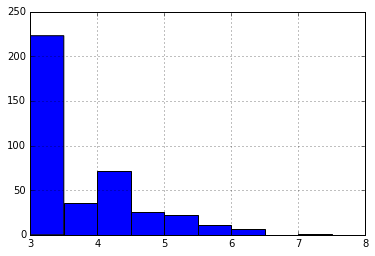

In [52]:
Bachelor.Years.hist(bins = 10, range=[3, 8])

### Female

In [53]:
Female = Bachelor[Bachelor.Civilité == 'Madame']
len(Female)

29

In [54]:
averageFemale = Female.Years.sum()/len(Female)
averageFemale

3.396551724137931

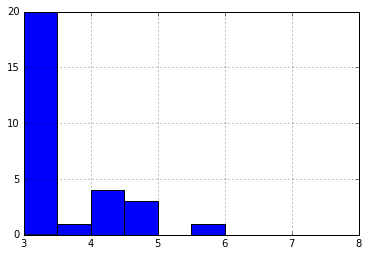

In [55]:
Female.Years.hist(bins = 10, range=[3, 8])


### Male

In [56]:
Male = Bachelor[Bachelor.Civilité == 'Monsieur']
len(Male)

368

In [57]:
average = Male.Years.sum()/len(Male)
average


3.573369565217391

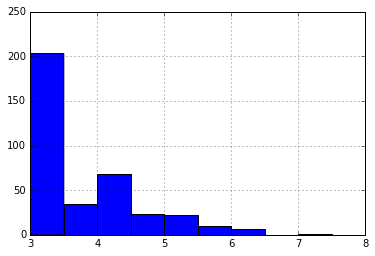

In [58]:
Male.Years.hist(bins = 10, range=[3, 8])